In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
data_dir = './data/dtd/'

images_dir = os.path.join(data_dir, 'images')
train_dir = os.path.join(images_dir, 'train')
test_dir = os.path.join(images_dir, 'test')
print(train_dir)

./data/dtd/images\train


In [4]:
means = torch.load("general_means.pt")
stds = torch.load("general_stds.pt")

In [ ]:
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_data)
stds /= len(train_data)
    
print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

In [5]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

In [6]:
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = train_transforms)

test_data = datasets.ImageFolder(root = test_dir, 
                                 transform = test_transforms)

In [7]:
print(train_data.classes.__len__())

47


In [8]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

In [9]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [10]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 3892
Number of validation examples: 433
Number of testing examples: 1315


In [11]:
BATCH_SIZE = 32

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE,
                                 num_workers=8)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE,
                                 num_workers=8)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

In [12]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image    

In [13]:
def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

In [ ]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

In [14]:
def format_label(label):
    label = label.split('.')[-1]
    label = label.replace('_', ' ')
    label = label.title()
    label = label.replace(' ', '')
    return label

In [ ]:
test_data.classes = [format_label(c) for c in test_data.classes]

classes = test_data.classes

plot_images(images, labels, classes)

## Define Inception Model

In [15]:
import warnings
from typing import Callable, Any, Optional, List

import torch
from torch import Tensor
from torch import nn

from torch.hub import load_state_dict_from_url

def _make_divisible(v: float, divisor: int, min_value: Optional[int] = None) -> int:
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def _log_api_usage_once(obj: Any) -> None:

    """
    Logs API usage(module and name) within an organization.
    In a large ecosystem, it's often useful to track the PyTorch and
    TorchVision APIs usage. This API provides the similar functionality to the
    logging module in the Python stdlib. It can be used for debugging purpose
    to log which methods are used and by default it is inactive, unless the user
    manually subscribes a logger via the `SetAPIUsageLogger method <https://github.com/pytorch/pytorch/blob/eb3b9fe719b21fae13c7a7cf3253f970290a573e/c10/util/Logging.cpp#L114>`_.
    Please note it is triggered only once for the same API call within a process.
    It does not collect any data from open-source users since it is no-op by default.
    For more information, please refer to
    * PyTorch note: https://pytorch.org/docs/stable/notes/large_scale_deployments.html#api-usage-logging;
    * Logging policy: https://github.com/pytorch/vision/issues/5052;

    Args:
        obj (class instance or method): an object to extract info from.
    """
    if not obj.__module__.startswith("torchvision"):
        return
    name = obj.__class__.__name__
    if isinstance(obj, FunctionType):
        name = obj.__name__
    torch._C._log_api_usage_once(f"{obj.__module__}.{name}")

class ConvNormActivation(torch.nn.Sequential):
    """
    Configurable block used for Convolution-Normalzation-Activation blocks.

    Args:
        in_channels (int): Number of channels in the input image
        out_channels (int): Number of channels produced by the Convolution-Normalzation-Activation block
        kernel_size: (int, optional): Size of the convolving kernel. Default: 3
        stride (int, optional): Stride of the convolution. Default: 1
        padding (int, tuple or str, optional): Padding added to all four sides of the input. Default: None, in wich case it will calculated as ``padding = (kernel_size - 1) // 2 * dilation``
        groups (int, optional): Number of blocked connections from input channels to output channels. Default: 1
        norm_layer (Callable[..., torch.nn.Module], optional): Norm layer that will be stacked on top of the convolutiuon layer. If ``None`` this layer wont be used. Default: ``torch.nn.BatchNorm2d``
        activation_layer (Callable[..., torch.nn.Module], optinal): Activation function which will be stacked on top of the normalization layer (if not None), otherwise on top of the conv layer. If ``None`` this layer wont be used. Default: ``torch.nn.ReLU``
        dilation (int): Spacing between kernel elements. Default: 1
        inplace (bool): Parameter for the activation layer, which can optionally do the operation in-place. Default ``True``
        bias (bool, optional): Whether to use bias in the convolution layer. By default, biases are included if ``norm_layer is None``.

    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int = 3,
        stride: int = 1,
        padding: Optional[int] = None,
        groups: int = 1,
        norm_layer: Optional[Callable[..., torch.nn.Module]] = torch.nn.BatchNorm2d,
        activation_layer: Optional[Callable[..., torch.nn.Module]] = torch.nn.ReLU,
        dilation: int = 1,
        inplace: Optional[bool] = True,
        bias: Optional[bool] = None,
    ) -> None:
        if padding is None:
            padding = (kernel_size - 1) // 2 * dilation
        if bias is None:
            bias = norm_layer is None
        layers = [
            torch.nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                dilation=dilation,
                groups=groups,
                bias=bias,
            )
        ]
        if norm_layer is not None:
            layers.append(norm_layer(out_channels))
        if activation_layer is not None:
            params = {} if inplace is None else {"inplace": inplace}
            layers.append(activation_layer(**params))
        super().__init__(*layers)
        _log_api_usage_once(self)
        self.out_channels = out_channels


__all__ = ["MobileNetV2", "mobilenet_v2"]


model_urls = {
    "mobilenet_v2": "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth",
}


# necessary for backwards compatibility
class _DeprecatedConvBNAct(ConvNormActivation):
    def __init__(self, *args, **kwargs):
        warnings.warn(
            "The ConvBNReLU/ConvBNActivation classes are deprecated since 0.12 and will be removed in 0.14. "
            "Use torchvision.ops.misc.ConvNormActivation instead.",
            FutureWarning,
        )
        if kwargs.get("norm_layer", None) is None:
            kwargs["norm_layer"] = nn.BatchNorm2d
        if kwargs.get("activation_layer", None) is None:
            kwargs["activation_layer"] = nn.ReLU6
        super().__init__(*args, **kwargs)


ConvBNReLU = _DeprecatedConvBNAct
ConvBNActivation = _DeprecatedConvBNAct


class InvertedResidual(nn.Module):
    def __init__(
        self, inp: int, oup: int, stride: int, expand_ratio: int, norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super().__init__()
        self.stride = stride
        assert stride in [1, 2]

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = self.stride == 1 and inp == oup

        layers: List[nn.Module] = []
        if expand_ratio != 1:
            # pw
            layers.append(
                ConvNormActivation(inp, hidden_dim, kernel_size=1, norm_layer=norm_layer, activation_layer=nn.ReLU6)
            )
        layers.extend(
            [
                # dw
                ConvNormActivation(
                    hidden_dim,
                    hidden_dim,
                    stride=stride,
                    groups=hidden_dim,
                    norm_layer=norm_layer,
                    activation_layer=nn.ReLU6,
                ),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                norm_layer(oup),
            ]
        )
        self.conv = nn.Sequential(*layers)
        self.out_channels = oup
        self._is_cn = stride > 1

    def forward(self, x: Tensor) -> Tensor:
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV2(nn.Module):
    def __init__(
        self,
        num_classes: int = 1000,
        width_mult: float = 1.0,
        inverted_residual_setting: Optional[List[List[int]]] = None,
        round_nearest: int = 8,
        block: Optional[Callable[..., nn.Module]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        dropout: float = 0.2,
    ) -> None:
        """
        MobileNet V2 main class

        Args:
            num_classes (int): Number of classes
            width_mult (float): Width multiplier - adjusts number of channels in each layer by this amount
            inverted_residual_setting: Network structure
            round_nearest (int): Round the number of channels in each layer to be a multiple of this number
            Set to 1 to turn off rounding
            block: Module specifying inverted residual building block for mobilenet
            norm_layer: Module specifying the normalization layer to use
            dropout (float): The droupout probability

        """
        super().__init__()
        _log_api_usage_once(self)

        if block is None:
            block = InvertedResidual

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        input_channel = 32
        last_channel = 1280

        if inverted_residual_setting is None:
            inverted_residual_setting = [
                # t, c, n, s
                [1, 16, 1, 1],
                [6, 24, 2, 2],
                [6, 32, 3, 2],
                [6, 64, 4, 2],
                [6, 96, 3, 1],
                [6, 160, 3, 2],
                [6, 320, 1, 1],
            ]

        # only check the first element, assuming user knows t,c,n,s are required
        if len(inverted_residual_setting) == 0 or len(inverted_residual_setting[0]) != 4:
            raise ValueError(
                f"inverted_residual_setting should be non-empty or a 4-element list, got {inverted_residual_setting}"
            )

        # building first layer
        input_channel = _make_divisible(input_channel * width_mult, round_nearest)
        self.last_channel = _make_divisible(last_channel * max(1.0, width_mult), round_nearest)
        features: List[nn.Module] = [
            ConvNormActivation(3, input_channel, stride=2, norm_layer=norm_layer, activation_layer=nn.ReLU6)
        ]
        # building inverted residual blocks
        for t, c, n, s in inverted_residual_setting:
            output_channel = _make_divisible(c * width_mult, round_nearest)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(block(input_channel, output_channel, stride, expand_ratio=t, norm_layer=norm_layer))
                input_channel = output_channel
        # building last several layers
        features.append(
            ConvNormActivation(
                input_channel, self.last_channel, kernel_size=1, norm_layer=norm_layer, activation_layer=nn.ReLU6
            )
        )
        # make it nn.Sequential
        self.features = nn.Sequential(*features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(self.last_channel, num_classes),
        )

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # This exists since TorchScript doesn't support inheritance, so the superclass method
        # (this one) needs to have a name other than `forward` that can be accessed in a subclass
        x = self.features(x)
        # Cannot use "squeeze" as batch-size can be 1
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def mobilenet_v2(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> MobileNetV2:
    """
    Constructs a MobileNetV2 architecture from
    `"MobileNetV2: Inverted Residuals and Linear Bottlenecks" <https://arxiv.org/abs/1801.04381>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = MobileNetV2(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls["mobilenet_v2"], progress=progress)
        model.load_state_dict(state_dict)
    return model


In [16]:
pretrained_model = models.mobilenet_v2(pretrained=True)
print(pretrained_model)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [17]:
model = MobileNetV2(num_classes=47)

In [18]:
OUTPUT_DIM = len(test_data.classes)

classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=False), 
    nn.Linear(in_features=1280, out_features=OUTPUT_DIM, bias=True)
    )

pretrained_model.classifier = classifier

In [19]:
model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,284,079 trainable parameters


In [21]:
print(model)

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

# Find best LR

In [22]:
START_LR = 1e-7

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

optimizer = optim.Adam(model.parameters(), lr=START_LR)

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

cuda


In [ ]:
from __future__ import print_function, with_statement, division
import copy
import os
import torch
from tqdm.autonotebook import tqdm
from torch.optim.lr_scheduler import _LRScheduler
import matplotlib.pyplot as plt


class LRFinder(object):
    """Learning rate range test.
    The learning rate range test increases the learning rate in a pre-training run
    between two boundaries in a linear or exponential manner. It provides valuable
    information on how well the network can be trained over a range of learning rates
    and what is the optimal learning rate.
    Arguments:
        model (torch.nn.Module): wrapped model.
        optimizer (torch.optim.Optimizer): wrapped optimizer where the defined learning
            is assumed to be the lower boundary of the range test.
        criterion (torch.nn.Module): wrapped loss function.
        device (str or torch.device, optional): a string ("cpu" or "cuda") with an
            optional ordinal for the device type (e.g. "cuda:X", where is the ordinal).
            Alternatively, can be an object representing the device on which the
            computation will take place. Default: None, uses the same device as `model`.
        memory_cache (boolean): if this flag is set to True, `state_dict` of model and
            optimizer will be cached in memory. Otherwise, they will be saved to files
            under the `cache_dir`.
        cache_dir (string): path for storing temporary files. If no path is specified,
            system-wide temporary directory is used.
            Notice that this parameter will be ignored if `memory_cache` is True.
    Example:
        >>> lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
        >>> lr_finder.range_test(dataloader, end_lr=100, num_iter=100)
    Cyclical Learning Rates for Training Neural Networks: https://arxiv.org/abs/1506.01186
    fastai/lr_find: https://github.com/fastai/fastai
    """

    def __init__(self, model, optimizer, criterion, device=None, memory_cache=True, cache_dir=None):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.history = {"lr": [], "loss": []}
        self.best_loss = None
        self.memory_cache = memory_cache
        self.cache_dir = cache_dir

        # Save the original state of the model and optimizer so they can be restored if
        # needed
        self.model_device = next(self.model.parameters()).device
        self.state_cacher = StateCacher(memory_cache, cache_dir=cache_dir)
        self.state_cacher.store('model', self.model.state_dict())
        self.state_cacher.store('optimizer', self.optimizer.state_dict())

        # If device is None, use the same as the model
        if device:
            self.device = device
        else:
            self.device = self.model_device

    def reset(self):
        """Restores the model and optimizer to their initial states."""
        self.model.load_state_dict(self.state_cacher.retrieve('model'))
        self.optimizer.load_state_dict(self.state_cacher.retrieve('optimizer'))
        self.model.to(self.model_device)

    def range_test(
        self,
        train_loader,
        val_loader=None,
        end_lr=10,
        num_iter=100,
        step_mode="exp",
        smooth_f=0.05,
        diverge_th=5,
    ):
        """Performs the learning rate range test.
        Arguments:
            train_loader (torch.utils.data.DataLoader): the training set data laoder.
            val_loader (torch.utils.data.DataLoader, optional): if `None` the range test
                will only use the training loss. When given a data loader, the model is
                evaluated after each iteration on that dataset and the evaluation loss
                is used. Note that in this mode the test takes significantly longer but
                generally produces more precise results. Default: None.
            end_lr (float, optional): the maximum learning rate to test. Default: 10.
            num_iter (int, optional): the number of iterations over which the test
                occurs. Default: 100.
            step_mode (str, optional): one of the available learning rate policies,
                linear or exponential ("linear", "exp"). Default: "exp".
            smooth_f (float, optional): the loss smoothing factor within the [0, 1[
                interval. Disabled if set to 0, otherwise the loss is smoothed using
                exponential smoothing. Default: 0.05.
            diverge_th (int, optional): the test is stopped when the loss surpasses the
                threshold:  diverge_th * best_loss. Default: 5.
        """
        # Reset test results
        self.history = {"lr": [], "loss": []}
        self.best_loss = None

        # Move the model to the proper device
        self.model.to(self.device)

        # Initialize the proper learning rate policy
        if step_mode.lower() == "exp":
            lr_schedule = ExponentialLR(self.optimizer, end_lr, num_iter)
        elif step_mode.lower() == "linear":
            lr_schedule = LinearLR(self.optimizer, end_lr, num_iter)
        else:
            raise ValueError("expected one of (exp, linear), got {}".format(step_mode))

        if smooth_f < 0 or smooth_f >= 1:
            raise ValueError("smooth_f is outside the range [0, 1[")

        # Create an iterator to get data batch by batch
        iterator = iter(train_loader)
        for iteration in tqdm(range(num_iter)):
            # Get a new set of inputs and labels
            try:
                inputs, labels = next(iterator)
            except StopIteration:
                iterator = iter(train_loader)
                inputs, labels = next(iterator)

            # Train on batch and retrieve loss
            loss = self._train_batch(inputs, labels)
            if val_loader:
                loss = self._validate(val_loader)

            # Update the learning rate
            lr_schedule.step()
            self.history["lr"].append(lr_schedule.get_lr()[0])

            # Track the best loss and smooth it if smooth_f is specified
            if iteration == 0:
                self.best_loss = loss
            else:
                if smooth_f > 0:
                    loss = smooth_f * loss + (1 - smooth_f) * self.history["loss"][-1]
                if loss < self.best_loss:
                    self.best_loss = loss

            # Check if the loss has diverged; if it has, stop the test
            self.history["loss"].append(loss)
            if loss > diverge_th * self.best_loss:
                print("Stopping early, the loss has diverged")
                break

        print("Learning rate search finished. See the graph with {finder_name}.plot()")
        return self.history

    def _train_batch(self, inputs, labels):
        # Set model to training mode
        self.model.train()

        # Move data to the correct device
        inputs = inputs.to(self.device)
        labels = labels.to(self.device)

        # Forward pass
        self.optimizer.zero_grad()
        outputs = self.model(inputs)
        loss = self.criterion(outputs, labels)

        # Backward pass
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def _validate(self, dataloader):
        # Set model to evaluation mode and disable gradient computation
        running_loss = 0
        self.model.eval()
        with torch.no_grad():
            for inputs, labels in dataloader:
                # Move data to the correct device
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                # Forward pass and loss computation
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)

        return running_loss / len(dataloader.dataset)

    def plot(self, skip_start=10, skip_end=5, log_lr=True):
        """Plots the learning rate range test.
        Arguments:
            skip_start (int, optional): number of batches to trim from the start.
                Default: 10.
            skip_end (int, optional): number of batches to trim from the start.
                Default: 5.
            log_lr (bool, optional): True to plot the learning rate in a logarithmic
                scale; otherwise, plotted in a linear scale. Default: True.
        """

        if skip_start < 0:
            raise ValueError("skip_start cannot be negative")
        if skip_end < 0:
            raise ValueError("skip_end cannot be negative")

        # Get the data to plot from the history dictionary. Also, handle skip_end=0
        # properly so the behaviour is the expected
        lrs = self.history["lr"]
        losses = self.history["loss"]
        if skip_end == 0:
            lrs = lrs[skip_start:]
            losses = losses[skip_start:]
        else:
            lrs = lrs[skip_start:-skip_end]
            losses = losses[skip_start:-skip_end]

        # Plot loss as a function of the learning rate
        plt.plot(lrs, losses)
        if log_lr:
            plt.xscale("log")
        plt.xlabel("Learning rate")
        plt.ylabel("Loss")
        plt.show()


class LinearLR(_LRScheduler):
    """Linearly increases the learning rate between two boundaries over a number of
    iterations.
    Arguments:
        optimizer (torch.optim.Optimizer): wrapped optimizer.
        end_lr (float, optional): the initial learning rate which is the lower
            boundary of the test. Default: 10.
        num_iter (int, optional): the number of iterations over which the test
            occurs. Default: 100.
        last_epoch (int): the index of last epoch. Default: -1.
    """

    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(LinearLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr + r * (self.end_lr - base_lr) for base_lr in self.base_lrs]


class ExponentialLR(_LRScheduler):
    """Exponentially increases the learning rate between two boundaries over a number of
    iterations.
    Arguments:
        optimizer (torch.optim.Optimizer): wrapped optimizer.
        end_lr (float, optional): the initial learning rate which is the lower
            boundary of the test. Default: 10.
        num_iter (int, optional): the number of iterations over which the test
            occurs. Default: 100.
        last_epoch (int): the index of last epoch. Default: -1.
    """

    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]


class StateCacher(object):
    def __init__(self, in_memory, cache_dir=None):
        self.in_memory = in_memory
        self.cache_dir = cache_dir

        if self.cache_dir is None:
            import tempfile
            self.cache_dir = tempfile.gettempdir()
        else:
            if not os.path.isdir(self.cache_dir):
                raise ValueError('Given `cache_dir` is not a valid directory.')

        self.cached = {}

    def store(self, key, state_dict):
        if self.in_memory:
            self.cached.update({key: copy.deepcopy(state_dict)})
        else:
            fn = os.path.join(self.cache_dir, 'state_{}_{}.pt'.format(key, id(self)))
            self.cached.update({key: fn})
            torch.save(state_dict, fn)

    def retrieve(self, key):
        if key not in self.cached:
            raise KeyError('Target {} was not cached.'.format(key))

        if self.in_memory:
            return self.cached.get(key)
        else:
            fn = self.cached.get(key)
            if not os.path.exists(fn):
                raise RuntimeError('Failed to load state in {}. File does not exist anymore.'.format(fn))
            state_dict = torch.load(fn, map_location=lambda storage, location: storage)
            return state_dict

    def __del__(self):
        if self.in_memory:
            return

        for k in self.cached:
            if os.path.exists(self.cached[k]):
                os.remove(self.cached[k])

In [23]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lr_finder.range_test(train_loader=train_iterator, end_lr=END_LR, num_iter=NUM_ITER)
lr_finder.plot()

NameError: name 'LRFinder' is not defined

In [24]:
history = lr_finder.history
print(history['lr'][history['loss'].index(min(history['loss']))])

NameError: name 'lr_finder' is not defined

In [25]:
FOUND_LR = 0.004

optimizer = optim.Adam(model.parameters(), lr = FOUND_LR)

In [ ]:
import torch.optim as optim
from ignite.contrib.handlers.param_scheduler import LRScheduler

EPOCHS = 10
scheduler = LRScheduler(optim.lr_scheduler.StepLR(optimizer, step_size = 8, gamma = 0.04))

In [26]:
def calculate_topk_accuracy(y_pred, y, topk=(1, )):
    maxk = max(topk)
    batch_size = y.size(0)

    _, top_pred = y_pred.topk(maxk, 1, True, True)
    top_pred = top_pred.t()
    correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
    
    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    
    return res

In [27]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [28]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = AverageMeter()
    epoch_acc_1 = AverageMeter()
    epoch_acc_5 = AverageMeter()
    
    model.train()
    
    for batch_idx, (x, y) in enumerate(iterator):
        x = x.to(device)
        y = y.to(device)

        y_pred = model(x)
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred.data, y.data, topk=(1, 5))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss.update(loss.item(), x.size(0))
        epoch_acc_1.update(acc_1.item(), x.size(0))
        epoch_acc_5.update(acc_5.item(), x.size(0))
        
    return float('{loss.avg:.4f}'.format(loss=epoch_loss)), float('{acc_1.avg:.4f}'.format(acc_1=epoch_acc_1)), float('{acc_5.avg:.4f}'.format(acc_5=epoch_acc_5))

In [29]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = AverageMeter()
    epoch_acc_1 = AverageMeter()
    epoch_acc_5 = AverageMeter()
    
    model.eval()
            
    for batch_idx, (x, y) in enumerate(iterator):

        x = x.to(device)
        y = y.to(device)

        y_pred = model(x)
        loss = criterion(y_pred, y)

        acc_1, acc_5 = calculate_topk_accuracy(y_pred.data, y.data, topk=(1, 5))

        epoch_loss.update(loss.data.item(), x.size(0))
        epoch_acc_1.update(acc_1.item(), x.size(0))
        epoch_acc_5.update(acc_5.item(), x.size(0))
        
    return float('{loss.avg:.4f}'.format(loss=epoch_loss)), float('{acc_1.avg:.4f}'.format(acc_1=epoch_acc_1)), float('{acc_5.avg:.4f}'.format(acc_5=epoch_acc_5))

In [30]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [31]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5:6.2f}%')

Epoch: 01 | Epoch Time: 0m 32s
	Train Loss: 3.775 | Train Acc @1:   6.68% | Train Acc @5:  26.34%
	Valid Loss: 3.517 | Valid Acc @1:   9.47% | Valid Acc @5:  30.25%
Epoch: 02 | Epoch Time: 0m 31s
	Train Loss: 3.298 | Train Acc @1:  10.46% | Train Acc @5:  40.39%
	Valid Loss: 3.119 | Valid Acc @1:  17.32% | Valid Acc @5:  51.04%
Epoch: 03 | Epoch Time: 0m 31s
	Train Loss: 3.018 | Train Acc @1:  15.57% | Train Acc @5:  50.21%
	Valid Loss: 2.934 | Valid Acc @1:  19.17% | Valid Acc @5:  50.35%
Epoch: 04 | Epoch Time: 0m 31s
	Train Loss: 2.847 | Train Acc @1:  19.50% | Train Acc @5:  55.76%
	Valid Loss: 2.771 | Valid Acc @1:  21.94% | Valid Acc @5:  59.58%
Epoch: 05 | Epoch Time: 0m 31s
	Train Loss: 2.690 | Train Acc @1:  22.15% | Train Acc @5:  60.15%
	Valid Loss: 2.723 | Valid Acc @1:  20.09% | Valid Acc @5:  62.36%
Epoch: 06 | Epoch Time: 0m 31s
	Train Loss: 2.628 | Train Acc @1:  24.00% | Train Acc @5:  62.26%
	Valid Loss: 2.748 | Valid Acc @1:  26.10% | Valid Acc @5:  63.05%
Epoch: 07 

## Examining the Model

In [32]:
model.load_state_dict(torch.load('tut5-model.pt'))

test_loss, test_acc_1, test_acc_5 = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc @1: {test_acc_1:6.2f}% | Test Acc @5: {test_acc_5:6.2f}%')

Test Loss: 2.618 | Test Acc @1:  28.52% | Test Acc @5:  65.32%


In [33]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [34]:
images, labels, probs = get_predictions(model, test_iterator)

In [35]:
pred_labels = torch.argmax(probs, 1)

In [36]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (50, 50));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    fig.delaxes(fig.axes[1]) #delete colorbar
    plt.xticks(rotation = 90)
    plt.xlabel('Predicted Label', fontsize = 50)
    plt.ylabel('True Label', fontsize = 50)

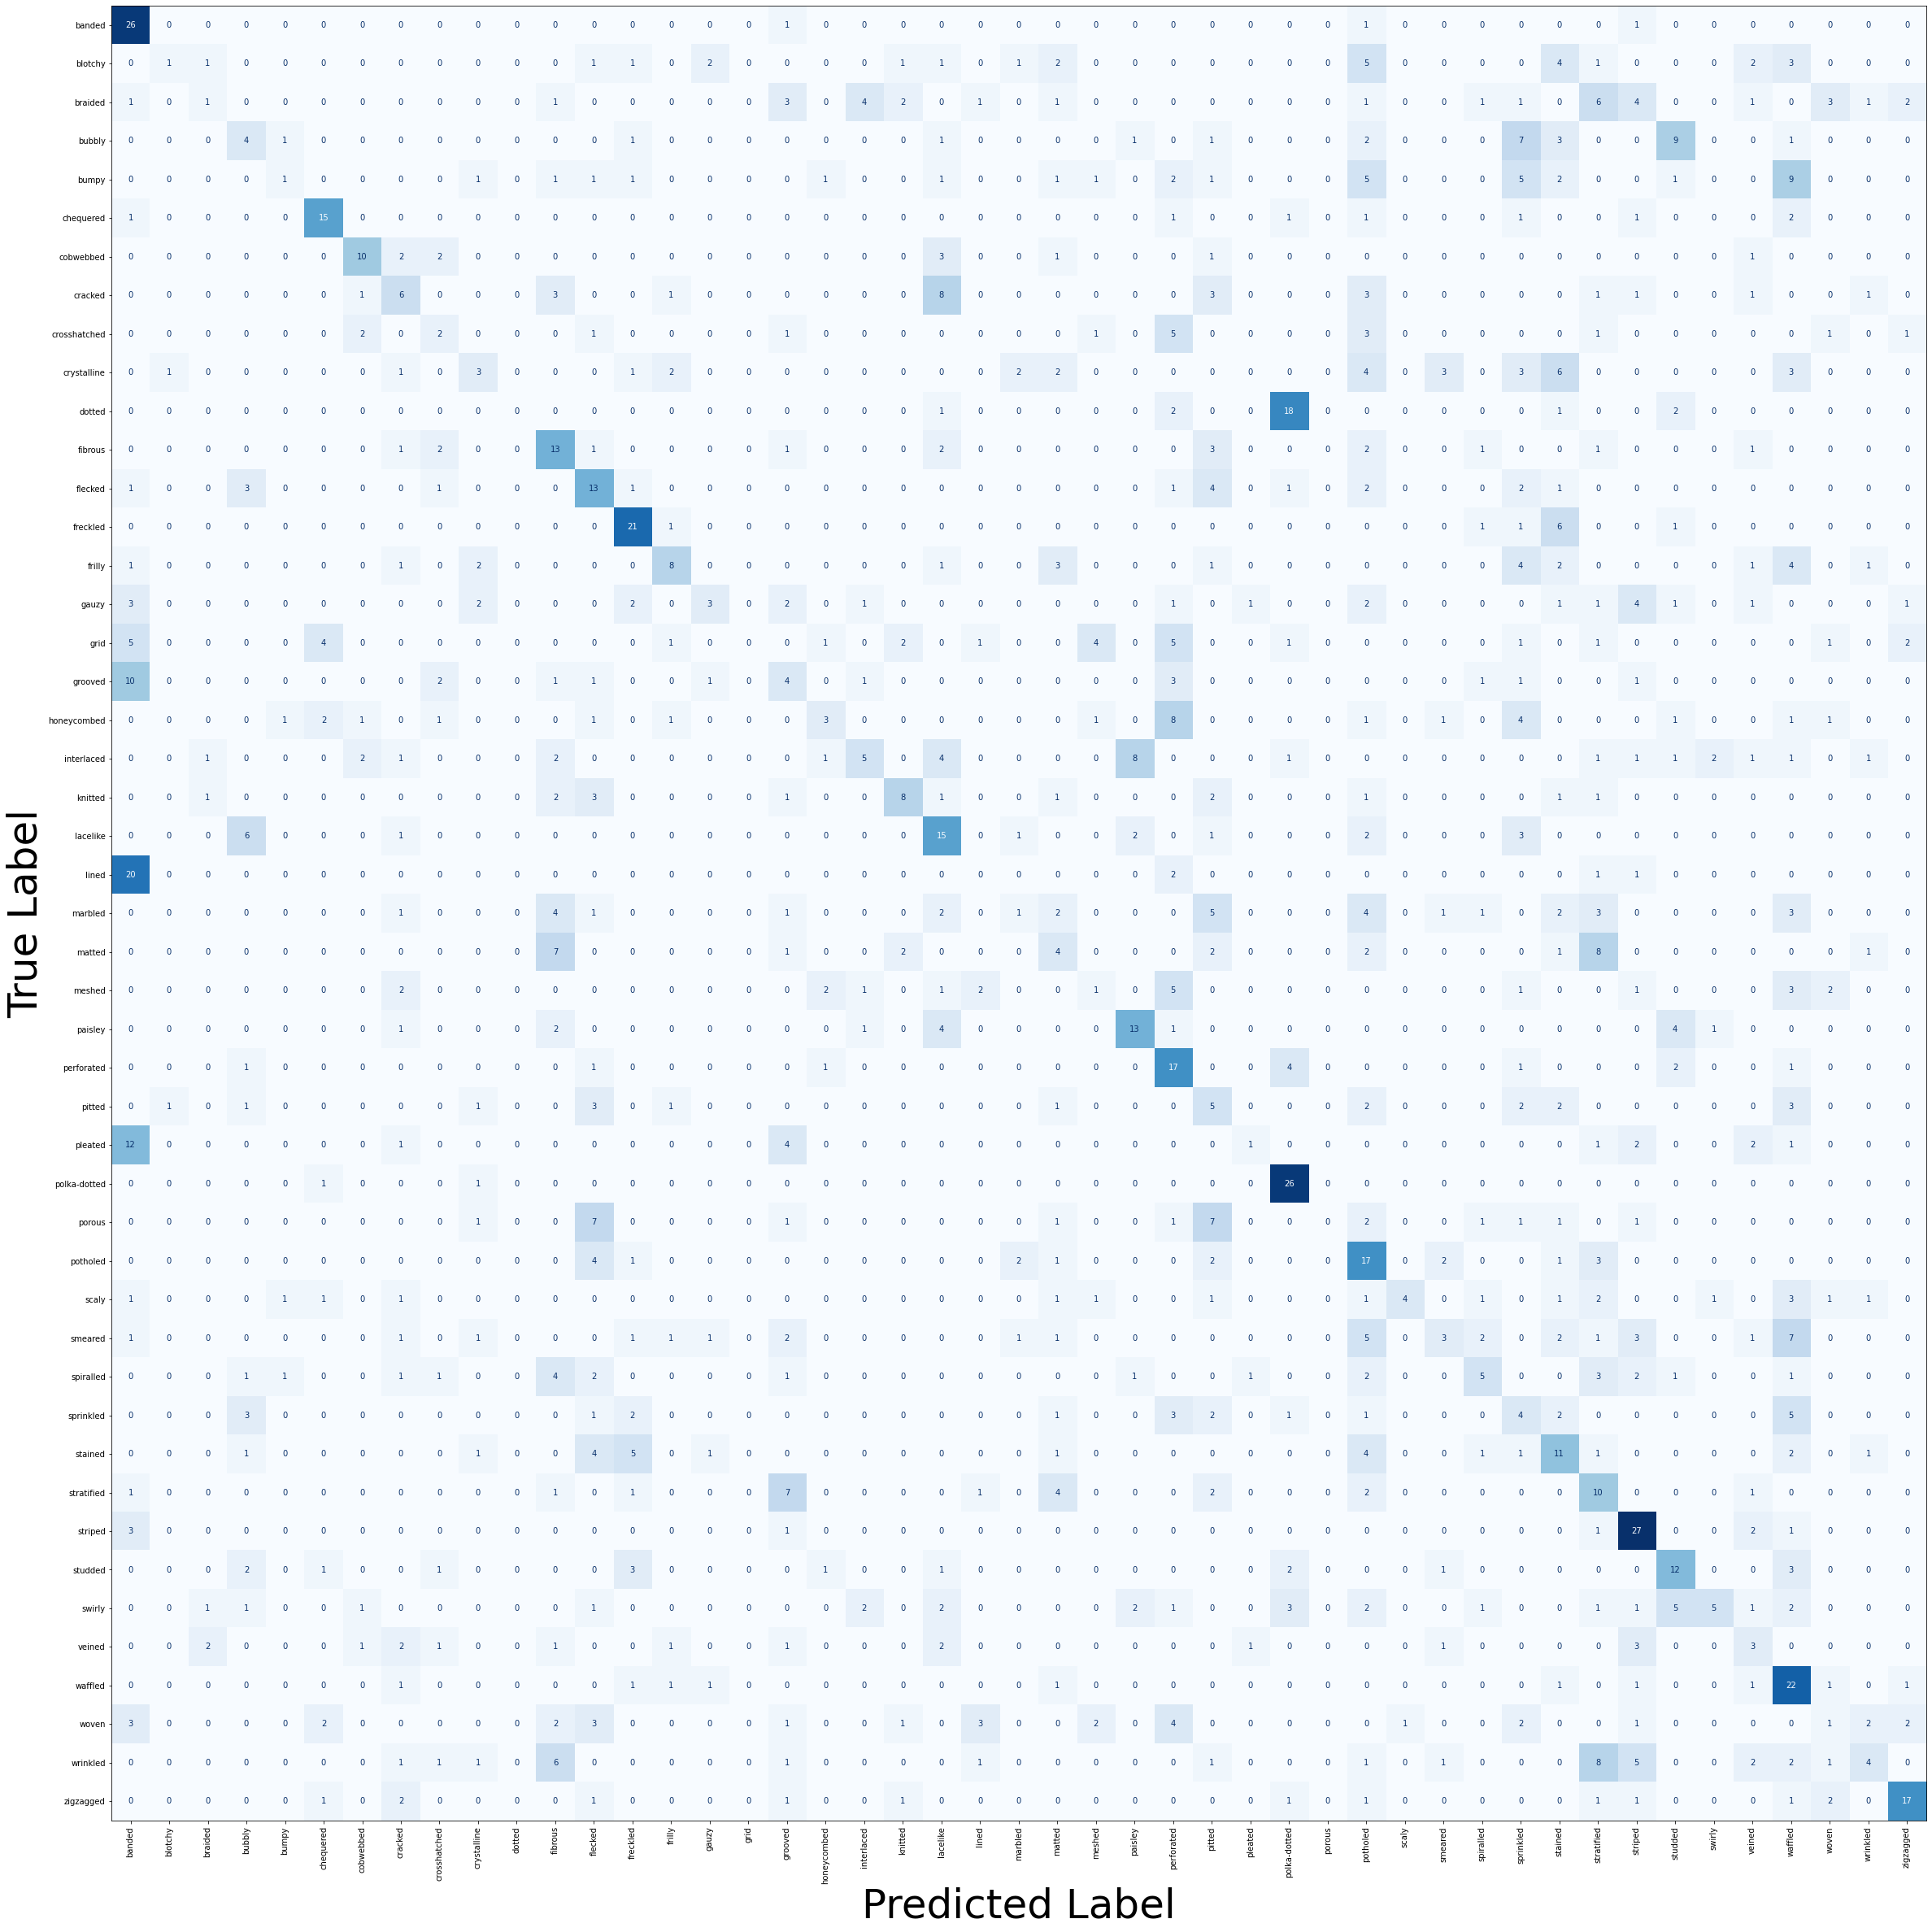

In [37]:
plot_confusion_matrix(labels, pred_labels, test_iterator.dataset.classes)